In [26]:
import os
from collections import Counter
import logging
import sys
from pathlib import Path
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import IPython
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from dotenv import load_dotenv
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from intervaltree import IntervalTree
import shutil

In [12]:
def find_comp_gen_dir():
    """Find the computational_genetic_genealogy directory by searching up from current directory."""
    current = Path.cwd()
    
    # Search up through parent directories
    while current != current.parent:
        # Check if target directory exists in current path
        target = current / 'computational_genetic_genealogy'
        if target.is_dir():
            return target
        # Move up one directory
        current = current.parent
    
    raise FileNotFoundError("Could not find computational_genetic_genealogy directory")

def load_env_file():
    """Find and load the .env file from the computational_genetic_genealogy directory."""
    try:
        # Find the computational_genetic_genealogy directory
        comp_gen_dir = find_comp_gen_dir()
        
        # Look for .env file
        env_path = comp_gen_dir / '.env'
        if not env_path.exists():
            print(f"Warning: No .env file found in {comp_gen_dir}")
            return None
        
        # Load the .env file
        load_dotenv(env_path, override=True)
        print(f"Loaded environment variables from: {env_path}")
        return env_path
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

# Use the function
env_path = load_env_file()

working_directory = os.getenv('PROJECT_WORKING_DIR', default=None)
data_directory = os.getenv('PROJECT_DATA_DIR', default=None)
references_directory = os.getenv('PROJECT_REFERENCES_DIR', default=None)
results_directory = os.getenv('PROJECT_RESULTS_DIR', default=None)
utils_directory = os.getenv('PROJECT_UTILS_DIR', default=None)

os.environ["WORKING_DIRECTORY"] = working_directory
os.environ["DATA_DIRECTORY"] = data_directory
os.environ["REFERENCES_DIRECTORY"] = references_directory
os.environ["RESULTS_DIRECTORY"] = results_directory
os.environ["UTILS_DIRECTORY"] = utils_directory

print(f"Working Directory: {working_directory}")
print(f"Data Directory: {data_directory}")
print(f"References Directory: {references_directory}")
print(f"Results Directory: {results_directory}")
print(f"Utils Directory: {utils_directory}")

os.chdir(working_directory)
print(f"The current directory is {os.getcwd()}")

Loaded environment variables from: /home/lakishadavid/computational_genetic_genealogy/.env
Working Directory: /home/lakishadavid/computational_genetic_genealogy
Data Directory: /home/lakishadavid/computational_genetic_genealogy/data
References Directory: /home/lakishadavid/computational_genetic_genealogy/references
Results Directory: /home/lakishadavid/computational_genetic_genealogy/results
Utils Directory: /home/lakishadavid/computational_genetic_genealogy/utils
The current directory is /home/lakishadavid/computational_genetic_genealogy


In [3]:
def configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO"):
    """
    Configure logging for both file and console handlers.

    Args:
        log_filename (str): Path to the log file where logs will be written.
        log_file_debug_level (str): Logging level for the file handler.
        console_debug_level (str): Logging level for the console handler.
    """
    # Create a root logger
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)  # Capture all messages at the root level

    # Convert level names to numeric levels
    file_level = getattr(logging, log_file_debug_level.upper(), logging.INFO)
    console_level = getattr(logging, console_debug_level.upper(), logging.INFO)

    # File handler: Logs messages at file_level and above to the file
    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(file_level)
    file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(file_formatter)

    # Console handler: Logs messages at console_level and above to the console
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(console_level)
    console_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(console_formatter)

    # Add handlers to the root logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
def clear_logger():
    """Remove all handlers from the root logger."""
    logger = logging.getLogger()
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)
        
log_filename = os.path.join(results_directory, "lab9_log.txt")
print(f"The Lab 9 log file is located at {log_filename}.")

# Ensure the results_directory exists
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Check if the file exists; if not, create it
if not os.path.exists(log_filename):
    with open(log_filename, 'w') as file:
        pass  # The file is now created.
    
clear_logger() # Clear the logger before reconfiguring it
configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO")

The Lab 9 log file is located at /home/lakishadavid/computational_genetic_genealogy/results/lab9_log.txt.


To run this notebook, you need to use the simulated data VCF file with Lab4 (skip the `Prepare Supplemental Data` section), Lab5, Lab6, and Lab7 first.

In [31]:
prefix = "ped_sim_run2_autosomes"
prefix_revised = prefix.replace("_autosomes", "")

source_path = Path(results_directory) / f"{prefix_revised}.seg"
destination_path = Path(results_directory) / prefix / "segments" / f"{prefix}.seg"

shutil.copy(source_path, destination_path)

PosixPath('/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/segments/ped_sim_run2_autosomes.seg')

In [34]:
segments_pedsim = Path(results_directory) / prefix / "segments" / f"{prefix}.seg"
segments_refinedibd = Path(results_directory) / prefix / "segments" / f"{prefix}_refinedibd.seg"
segments_hapibd = Path(results_directory) / prefix / "segments" / f"{prefix}_hapibd.seg"
segments_ibis = Path(results_directory) / prefix / "segments" / f"{prefix}_ibis.seg"


segment_files = [segments_pedsim, segments_refinedibd, segments_hapibd, segments_ibis, ]

# Check if each file exists
for file_path in segment_files:
    if not file_path.exists():
        print(f"Warning: File not found - {file_path}")
    else:
        print(f"File exists: {file_path}")

File exists: /home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/segments/ped_sim_run2_autosomes.seg
File exists: /home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/segments/ped_sim_run2_autosomes_refinedibd.seg
File exists: /home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/segments/ped_sim_run2_autosomes_hapibd.seg
File exists: /home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/segments/ped_sim_run2_autosomes_ibis.seg


In [35]:
def load_refined_ibd(filepath):
    """Load Refined IBD output file"""
    try:
        df = pd.read_csv(filepath, sep="\t", header=None)
        df.columns = ["sample1", "sample1_haplotype", "sample2", 
                      "sample2_haplotype", "chrom", "start", "end", "LOD", "cM"]
        # Create a unique segment ID for each segment
        df['segment_id'] = range(len(df))
        df['tool'] = 'RefinedIBD'
        df['length'] = df['end'] - df['start']
        return df
    except Exception as e:
        print(f"Error loading Refined IBD file: {e}")
        cols = ["sample1", "sample1_haplotype", "sample2", "sample2_haplotype", 
                "chrom", "start", "end", "LOD", "cM"]
        return pd.DataFrame(columns=cols + ['segment_id', 'tool', 'length'])

def load_hap_ibd(filepath):
   """Load Hap IBD output file"""
   try:
       df = pd.read_csv(filepath, sep="\t", header=None)
       df.columns = ["sample1", "sample1_haplotype", "sample2", 
                     "sample2_haplotype", "chrom", "start", "end", "cM"]
       df['segment_id'] = range(len(df))
       df['tool'] = 'HapIBD'
       df['length'] = df['end'] - df['start']
       # Since LOD isn't in the HapIBD output, create a placeholder or use cM as proxy
       df['LOD'] = df['cM']  # Using cM as a proxy for confidence
       return df
   except Exception as e:
       print(f"Error loading Hap IBD file: {e}")
       cols = ["sample1", "sample1_haplotype", "sample2", "sample2_haplotype", 
               "chrom", "start", "end", "cM"]
       return pd.DataFrame(columns=cols + ['segment_id', 'tool', 'length', 'LOD'])

def load_ibis(filepath):
    """Load IBIS output file"""
    try:
        df = pd.read_csv(filepath, sep="\t", header=None)
        df.columns = ["sample1", "sample2", "chrom", 
                    "phys_start_pos", "phys_end_pos", 
                    "IBD_type", "genetic_start_pos", 
                    "genetic_end_pos", "genetic_seg_length", 
                    "marker_count", "error_count", "error_density"]
        
        # Map IBIS columns to standardized column names for evaluation
        df['start'] = df['phys_start_pos']
        df['end'] = df['phys_end_pos']
        df['cM'] = df['genetic_seg_length']
        df['segment_id'] = range(len(df))
        df['tool'] = 'IBIS'
        df['length'] = df['end'] - df['start']
        
        # Create LOD-like score based on error density (lower error = higher score)
        # Invert error_density to make higher values better
        df['LOD'] = 1.0 / (df['error_density'] + 0.001)  # Add small constant to avoid division by zero
        
        # Add haplotype columns if needed for consistent evaluation
        df['sample1_haplotype'] = 0  # Placeholder if IBIS doesn't specify haplotypes
        df['sample2_haplotype'] = 0
        
        return df
    except Exception as e:
        print(f"Error loading IBIS file: {e}")
        cols = ["sample1", "sample2", "chrom", "phys_start_pos", "phys_end_pos", 
                "IBD_type", "genetic_start_pos", "genetic_end_pos", "genetic_seg_length", 
                "marker_count", "error_count", "error_density"]
        return pd.DataFrame(columns=cols + ['start', 'end', 'segment_id', 'tool', 'length', 'LOD', 
                                           'sample1_haplotype', 'sample2_haplotype'])

def load_pedsim_truth(filepath):
   """Load ground truth IBD segments from ped-sim"""
   try:
       df = pd.read_csv(filepath, sep="\t", header=None)
       df.columns = ["id1", "id2", "chromosome", "physical_position_start", 
                    "physical_position_end", "IBD_type", "genetic_position_start", 
                    "genetic_position_end", "genetic_length"]
       
       # Map to standardized column names used in evaluation
       df['sample1'] = df['id1']
       df['sample2'] = df['id2']
       df['chrom'] = df['chromosome']
       df['start'] = df['physical_position_start']
       df['end'] = df['physical_position_end']
       df['cM'] = df['genetic_length']
       df['sample1_haplotype'] = 0  # Add placeholder haplotypes if needed
       df['sample2_haplotype'] = 0  # These can be updated if actual haplotype info exists
       
       df['segment_id'] = range(len(df))
       df['tool'] = 'Truth'
       df['length'] = df['end'] - df['start']
       return df
   except Exception as e:
       print(f"Error loading PedSim truth file: {e}")
       cols = ["id1", "id2", "chromosome", "physical_position_start", 
              "physical_position_end", "IBD_type", "genetic_position_start", 
              "genetic_position_end", "genetic_length"]
       return pd.DataFrame(columns=cols + ['sample1', 'sample2', 'chrom', 'start', 'end', 
                                         'cM', 'segment_id', 'tool', 'length',
                                         'sample1_haplotype', 'sample2_haplotype'])

In [36]:
refined_df = load_refined_ibd(segments_refinedibd)
hap_df = load_hap_ibd(segments_hapibd)
ibis_df = load_ibis(segments_ibis)
truth_df = load_pedsim_truth(segments_pedsim)

# Print data summaries
print(f"Loaded {len(refined_df)} Refined IBD segments")
print(f"Loaded {len(hap_df)} Hap IBD segments")
print(f"Loaded {len(ibis_df)} IBIS segments")
print(f"Loaded {len(truth_df)} truth segments from ped-sim")

Error loading Hap IBD file: No columns to parse from file
Loaded 200681 Refined IBD segments
Loaded 0 Hap IBD segments
Loaded 748898 IBIS segments
Loaded 183061 truth segments from ped-sim


In [ ]:
def create_interval_tree(truth_df):
    """Create an interval tree from truth segments for efficient overlap checking"""
    trees = {}
    
    print("Building interval trees from truth data...")
    
    # First try with standard column names
    if all(col in truth_df.columns for col in ['sample1', 'sample2', 'chrom', 'start', 'end']):
        sample1_col, sample2_col = 'sample1', 'sample2'
    # Then try with ped-sim column names
    elif all(col in truth_df.columns for col in ['id1', 'id2', 'chromosome', 'physical_position_start', 'physical_position_end']):
        sample1_col, sample2_col = 'id1', 'id2'
        # Map columns for consistency
        truth_df['sample1'] = truth_df['id1']
        truth_df['sample2'] = truth_df['id2']
        truth_df['chrom'] = truth_df['chromosome']
        truth_df['start'] = truth_df['physical_position_start']
        truth_df['end'] = truth_df['physical_position_end']
    else:
        print("Error: Could not identify required columns in truth data")
        return trees
    
    # Add haplotype columns if they don't exist
    if 'sample1_haplotype' not in truth_df.columns:
        truth_df['sample1_haplotype'] = 0
    if 'sample2_haplotype' not in truth_df.columns:
        truth_df['sample2_haplotype'] = 0
    
    # Create trees with and without haplotype information
    for _, row in truth_df.iterrows():
        # Create keys in both orders to handle either order in tool data
        pairs = [
            # With haplotypes
            ((row['sample1'], row['sample1_haplotype']), 
             (row['sample2'], row['sample2_haplotype']), 
             row['chrom']),
            ((row['sample2'], row['sample2_haplotype']), 
             (row['sample1'], row['sample1_haplotype']), 
             row['chrom']),
            # Without haplotypes
            ((row['sample1'], None), (row['sample2'], None), row['chrom']),
            ((row['sample2'], None), (row['sample1'], None), row['chrom'])
        ]
        
        for sample1, sample2, chrom in pairs:
            pair_key = (sample1, sample2)
            if (pair_key, chrom) not in trees:
                trees[(pair_key, chrom)] = IntervalTree()
            
            trees[(pair_key, chrom)].addi(row['start'], row['end'], row['segment_id'])
    
    print(f"Created {len(trees)} interval trees")
    return trees

def calculate_overlap(segment, tree):
    """Calculate overlap between a segment and truth segments in the tree"""
    overlaps = tree.overlap(segment['start'], segment['end'])
    if not overlaps:
        return 0, None
    
    # Find the best overlapping segment
    best_overlap = 0
    best_truth_id = None
    
    for interval in overlaps:
        overlap_start = max(segment['start'], interval.begin)
        overlap_end = min(segment['end'], interval.end)
        overlap_length = overlap_end - overlap_start
        
        if overlap_length > best_overlap:
            best_overlap = overlap_length
            best_truth_id = interval.data
    
    return best_overlap / (segment['end'] - segment['start']), best_truth_id

def evaluate_tool(tool_df, truth_trees):
    """Evaluate IBD detection performance for a specific tool"""
    # If the DataFrame is empty, return it without processing
    if len(tool_df) == 0:
        print(f"Tool: {tool_df.name if hasattr(tool_df, 'name') else 'Unknown'} - No segments to evaluate")
        return tool_df
        
    # Add columns for evaluation metrics
    tool_df['detected_truth'] = False
    tool_df['overlap_pct'] = 0.0
    tool_df['truth_id'] = None
    
    # Debug counters
    total_segments = len(tool_df)
    matched_segments = 0
    
    for idx, row in tool_df.iterrows():
        # Check if we have both sample pair in regular and reversed order
        sample_pairs = [
            # Regular order
            ((row['sample1'], row.get('sample1_haplotype', 0)), 
             (row['sample2'], row.get('sample2_haplotype', 0)),
             row['chrom']),
            # Reversed order
            ((row['sample2'], row.get('sample2_haplotype', 0)), 
             (row['sample1'], row.get('sample1_haplotype', 0)),
             row['chrom'])
        ]
        
        found_match = False
        for sample1, sample2, chrom in sample_pairs:
            pair_key = (sample1, sample2)
            if (pair_key, chrom) in truth_trees:
                overlap_pct, truth_id = calculate_overlap(row, truth_trees[(pair_key, chrom)])
                if overlap_pct > 0:
                    tool_df.at[idx, 'overlap_pct'] = overlap_pct
                    tool_df.at[idx, 'truth_id'] = truth_id
                    tool_df.at[idx, 'detected_truth'] = (overlap_pct >= 0.5)  # Consider >=50% overlap a true positive
                    matched_segments += 1 if overlap_pct >= 0.5 else 0
                    found_match = True
                    break
        
        # Try without haplotypes if no match found and haplotypes present
        if not found_match and 'sample1_haplotype' in row:
            # Create keys without haplotype information
            sample_pairs_no_hap = [
                ((row['sample1'], None), (row['sample2'], None), row['chrom']),
                ((row['sample2'], None), (row['sample1'], None), row['chrom'])
            ]
            
            for sample1, sample2, chrom in sample_pairs_no_hap:
                pair_key = (sample1, sample2)
                if (pair_key, chrom) in truth_trees:
                    overlap_pct, truth_id = calculate_overlap(row, truth_trees[(pair_key, chrom)])
                    if overlap_pct > 0:
                        tool_df.at[idx, 'overlap_pct'] = overlap_pct
                        tool_df.at[idx, 'truth_id'] = truth_id
                        tool_df.at[idx, 'detected_truth'] = (overlap_pct >= 0.5)
                        matched_segments += 1 if overlap_pct >= 0.5 else 0
                        break
    
    # Get the tool name safely
    tool_name = tool_df['tool'].iloc[0] if len(tool_df) > 0 else "Unknown"
    
    # Calculate percentage safely
    percentage = (matched_segments/total_segments*100) if total_segments > 0 else 0
    
    print(f"Tool: {tool_name} - Matched {matched_segments} of {total_segments} segments ({percentage:.2f}%)")
    return tool_df

def evaluate_all_tools(refined_df, hap_df, ibis_df, truth_df):
    """Evaluate all IBD detection tools"""
    # Create interval trees for truth segments
    truth_trees = create_interval_tree(truth_df)
    
    # Evaluate each tool
    refined_eval = evaluate_tool(refined_df, truth_trees)
    
    # Only evaluate tools with data
    if len(hap_df) > 0:
        hap_eval = evaluate_tool(hap_df, truth_trees)
    else:
        print("Tool: HapIBD - No segments to evaluate")
        hap_eval = hap_df.copy()
        hap_eval['tool'] = 'HapIBD'  # Ensure tool column exists
    
    ibis_eval = evaluate_tool(ibis_df, truth_trees)
    
    # Combine results
    all_results = pd.concat([refined_eval, hap_eval, ibis_eval], ignore_index=True)
    
    return all_results, truth_df

In [42]:
# Evaluate tools
print("Evaluating IBD detection tools...")
all_results, truth_df = evaluate_all_tools(refined_df, hap_df, ibis_df, truth_df)
print("Done!")


Evaluating IBD detection tools...
Building interval trees from truth data...
Created 292748 interval trees
Tool: RefinedIBD - Matched 186641 of 200681 segments (93.00%)
Tool: HapIBD - No segments to evaluate
Tool: IBIS - Matched 26951 of 748898 segments (3.60%)


/tmp/ipykernel_1084/1664074056.py:165: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([refined_eval, hap_eval, ibis_eval])


Done!


In [43]:
def diagnose_data_format_issues(all_results, truth_df):
    """Diagnose potential format inconsistencies between tool outputs and truth data"""
    print("\n=== Data Format Diagnosis ===")
    
    # Check chromosome formats
    truth_chroms = set(truth_df['chrom'].unique())
    print(f"Truth data chromosome formats (sample of 5): {list(truth_chroms)[:5]}")
    
    for tool_name in ['RefinedIBD', 'HapIBD', 'IBIS']:
        tool_df = all_results[all_results['tool'] == tool_name]
        if len(tool_df) == 0:
            continue
            
        tool_chroms = set(tool_df['chrom'].unique())
        print(f"{tool_name} chromosome formats (sample of 5): {list(tool_chroms)[:5]}")
        
        # Check for chromosome format mismatches
        if not truth_chroms.intersection(tool_chroms):
            print(f"⚠️ WARNING: No matching chromosome formats between truth and {tool_name}!")
            print(f"  Consider standardizing chromosome formats (e.g., '1' vs 'chr1')")
    
    # Check sample ID formats
    if 'sample1' in truth_df.columns and 'sample2' in truth_df.columns:
        truth_samples = set(truth_df['sample1'].unique()).union(set(truth_df['sample2'].unique()))
        print(f"Truth data sample ID formats (sample of 5): {list(truth_samples)[:5]}")
        
        for tool_name in ['RefinedIBD', 'HapIBD', 'IBIS']:
            tool_df = all_results[all_results['tool'] == tool_name]
            if len(tool_df) == 0 or 'sample1' not in tool_df.columns or 'sample2' not in tool_df.columns:
                continue
                
            tool_samples = set(tool_df['sample1'].unique()).union(set(tool_df['sample2'].unique()))
            print(f"{tool_name} sample ID formats (sample of 5): {list(tool_samples)[:5]}")
            
            # Check for sample ID format mismatches
            if not truth_samples.intersection(tool_samples):
                print(f"⚠️ WARNING: No matching sample IDs between truth and {tool_name}!")
                print(f"  Consider standardizing sample ID formats")
    
    # Check position ranges
    truth_min_pos = truth_df['start'].min()
    truth_max_pos = truth_df['end'].max()
    print(f"Truth data position range: {truth_min_pos:,} - {truth_max_pos:,}")
    
    for tool_name in ['RefinedIBD', 'HapIBD', 'IBIS']:
        tool_df = all_results[all_results['tool'] == tool_name]
        if len(tool_df) == 0:
            continue
            
        tool_min_pos = tool_df['start'].min()
        tool_max_pos = tool_df['end'].max()
        print(f"{tool_name} position range: {tool_min_pos:,} - {tool_max_pos:,}")
        
        # Check for major position range mismatches
        if (tool_min_pos > truth_max_pos) or (tool_max_pos < truth_min_pos):
            print(f"⚠️ WARNING: Position ranges don't overlap between truth and {tool_name}!")
            print(f"  Consider checking for coordinate system differences")
    
    print("\n=== End of Diagnosis ===")

In [44]:
diagnose_data_format_issues(all_results, truth_df)


=== Data Format Diagnosis ===
Truth data chromosome formats (sample of 5): [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
RefinedIBD chromosome formats (sample of 5): [1, 2, 3, 4, 5]
IBIS chromosome formats (sample of 5): [1, 2, 3, 4, 5]
Truth data sample ID formats (sample of 5): ['FAM2_g6-b6-i1', 'FAM6_g5-b3-s1', 'FAM10_g5-b8-s1', 'FAM4_g5-b5-i1', 'FAM10_g5-b8-i1']
RefinedIBD sample ID formats (sample of 5): ['FAM6_g5-b3-s1', 'FAM2_g6-b6-i1', 'FAM10_g5-b8-s1', 'FAM4_g5-b5-i1', 'FAM10_g5-b8-i1']
IBIS sample ID formats (sample of 5): ['FAM2_g6-b6-i1', 'FAM6_g5-b3-s1', 'FAM10_g5-b8-s1', 'FAM4_g5-b5-i1', 'FAM10_g5-b8-i1']
Truth data position range: 46,239 - 248,876,512
RefinedIBD position range: 46,239 - 248,918,526
IBIS position range: 46,239 - 248,918,526

=== End of Diagnosis ===


In [45]:
def plot_length_distribution(all_results, truth_df):
    """Plot the distribution of segment lengths for each tool and truth"""
    plt.figure(figsize=(12, 8))
    
    # Combine all data
    all_data = pd.concat([
        all_results[all_results['tool'] == 'RefinedIBD'][['length', 'tool']],
        all_results[all_results['tool'] == 'HapIBD'][['length', 'tool']],
        all_results[all_results['tool'] == 'IBIS'][['length', 'tool']],
        truth_df[['length', 'tool']]
    ])
    
    # Convert length from bp to Mbp
    all_data['length'] = all_data['length'] / 1_000_000
    
    # Plot density
    sns.kdeplot(data=all_data, x='length', hue='tool', fill=True, alpha=0.5)
    
    plt.title('Distribution of IBD Segment Lengths')
    plt.xlabel('Segment Length (Mbp)')
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('ibd_length_distribution.png')
    plt.show()

def plot_precision_recall(all_results, truth_df):
    """Plot precision-recall curves for each tool"""
    plt.figure(figsize=(10, 8))
    
    has_data = False
    # For each tool, calculate precision and recall using overlap percentage as score
    for tool_name, color in zip(['RefinedIBD', 'HapIBD', 'IBIS'], ['blue', 'green', 'red']):
        tool_df = all_results[all_results['tool'] == tool_name]
        
        # Skip if no data for this tool
        if len(tool_df) == 0:
            continue
            
        # Check if we have true positives
        if tool_df['detected_truth'].sum() == 0:
            print(f"Warning: No true positives found for {tool_name}, skipping PR curve")
            continue
            
        has_data = True
        
        if 'LOD' in tool_df.columns and not tool_df['LOD'].isna().all():
            score = tool_df['LOD']  # Use LOD score if available
        else:
            score = tool_df['length']  # Otherwise use length as a proxy for confidence
            
        y_true = tool_df['detected_truth'].astype(int)
        
        try:
            # Calculate precision and recall
            precision, recall, _ = precision_recall_curve(y_true, score)
            avg_precision = average_precision_score(y_true, score)
            
            # Plot PR curve
            plt.plot(recall, precision, lw=2, color=color,
                     label=f'{tool_name} (AP={avg_precision:.2f})')
        except Exception as e:
            print(f"Error plotting PR curve for {tool_name}: {e}")
    
    if has_data:
        plt.title('Precision-Recall Curves for IBD Detection Tools')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc="best")
        plt.tight_layout()
        plt.savefig('ibd_precision_recall.png')
        plt.show()
    else:
        print("Skipping PR curve plot: No valid data")

def plot_roc_curves(all_results, truth_df):
    """Plot ROC curves for each tool"""
    plt.figure(figsize=(10, 8))
    
    has_data = False
    # For each tool, calculate ROC using overlap percentage as score
    for tool_name, color in zip(['RefinedIBD', 'HapIBD', 'IBIS'], ['blue', 'green', 'red']):
        tool_df = all_results[all_results['tool'] == tool_name]
        
        # Skip if no data for this tool
        if len(tool_df) == 0:
            continue
            
        # Check if we have true positives
        if tool_df['detected_truth'].sum() == 0:
            print(f"Warning: No true positives found for {tool_name}, skipping ROC curve")
            continue
            
        has_data = True
        
        if 'LOD' in tool_df.columns and not tool_df['LOD'].isna().all():
            score = tool_df['LOD']  # Use LOD score if available
        else:
            score = tool_df['length']  # Otherwise use length as a proxy for confidence
            
        y_true = tool_df['detected_truth'].astype(int)
        
        try:
            # Calculate ROC
            fpr, tpr, _ = roc_curve(y_true, score)
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve
            plt.plot(fpr, tpr, lw=2, color=color,
                     label=f'{tool_name} (AUC={roc_auc:.2f})')
        except Exception as e:
            print(f"Error plotting ROC curve for {tool_name}: {e}")
    
    if has_data:
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8)
        plt.title('ROC Curves for IBD Detection Tools')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig('ibd_roc_curves.png')
        plt.show()
    else:
        print("Skipping ROC curve plot: No valid data")

def plot_overlap_histogram(all_results):
    """Plot histogram of overlap percentages for each tool"""
    plt.figure(figsize=(12, 8))
    
    for tool_name, color in zip(['RefinedIBD', 'HapIBD', 'IBIS'], ['blue', 'green', 'red']):
        tool_df = all_results[all_results['tool'] == tool_name]
        plt.hist(tool_df['overlap_pct'], bins=20, alpha=0.5, color=color, label=tool_name)
    
    plt.title('Distribution of Overlap with Truth Segments')
    plt.xlabel('Overlap Percentage')
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig('ibd_overlap_histogram.png')
    plt.show()

Generating visualizations...


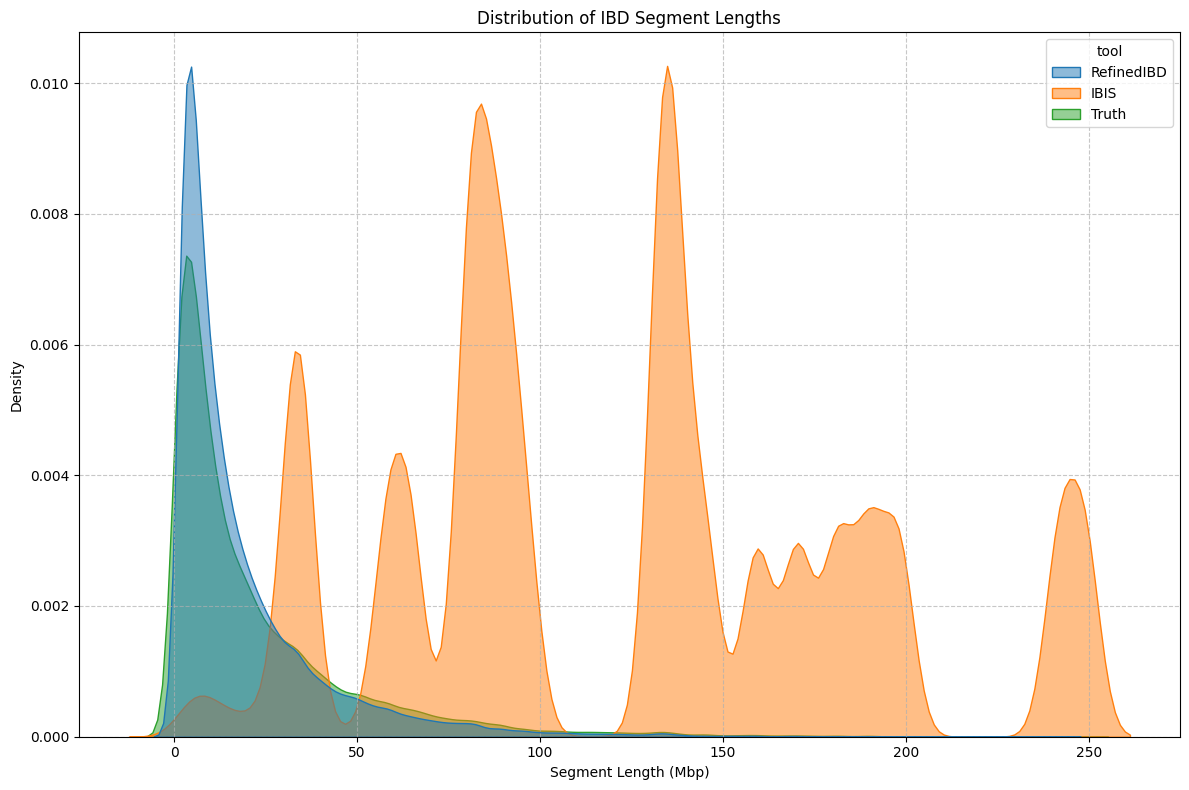

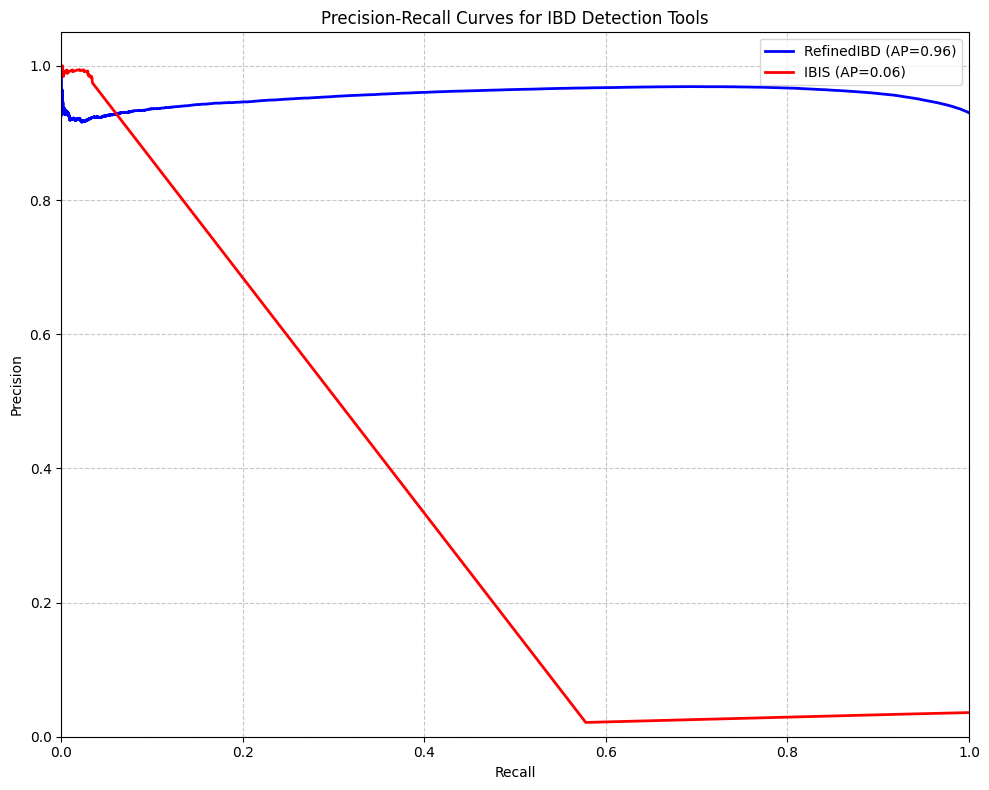

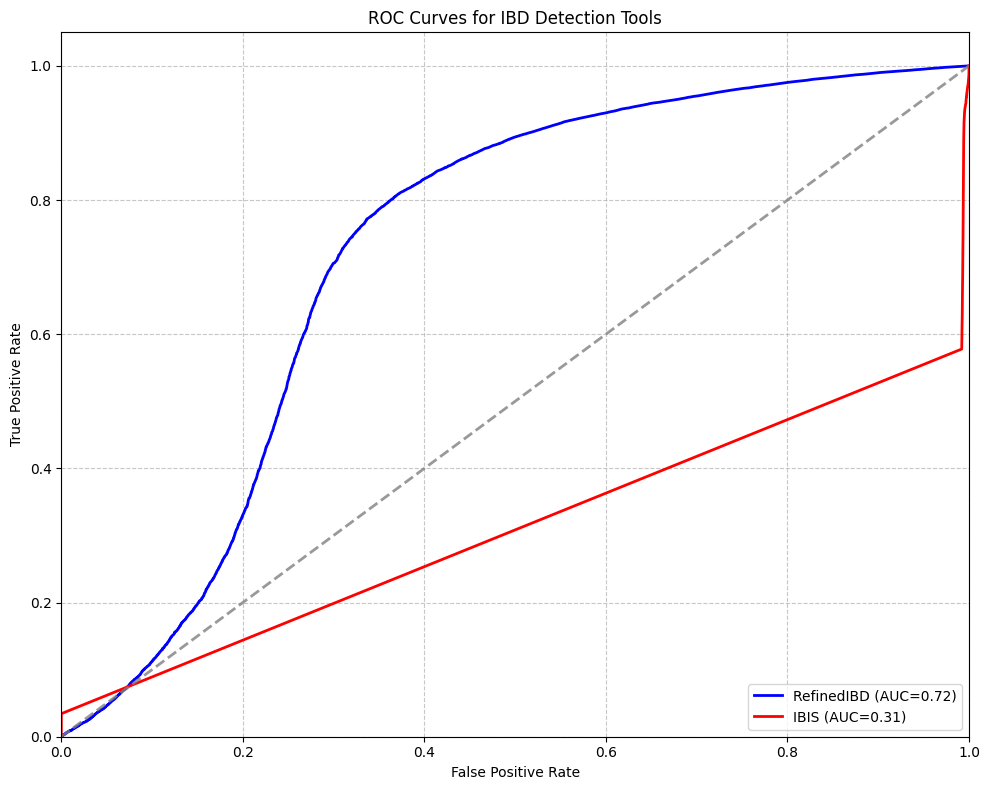

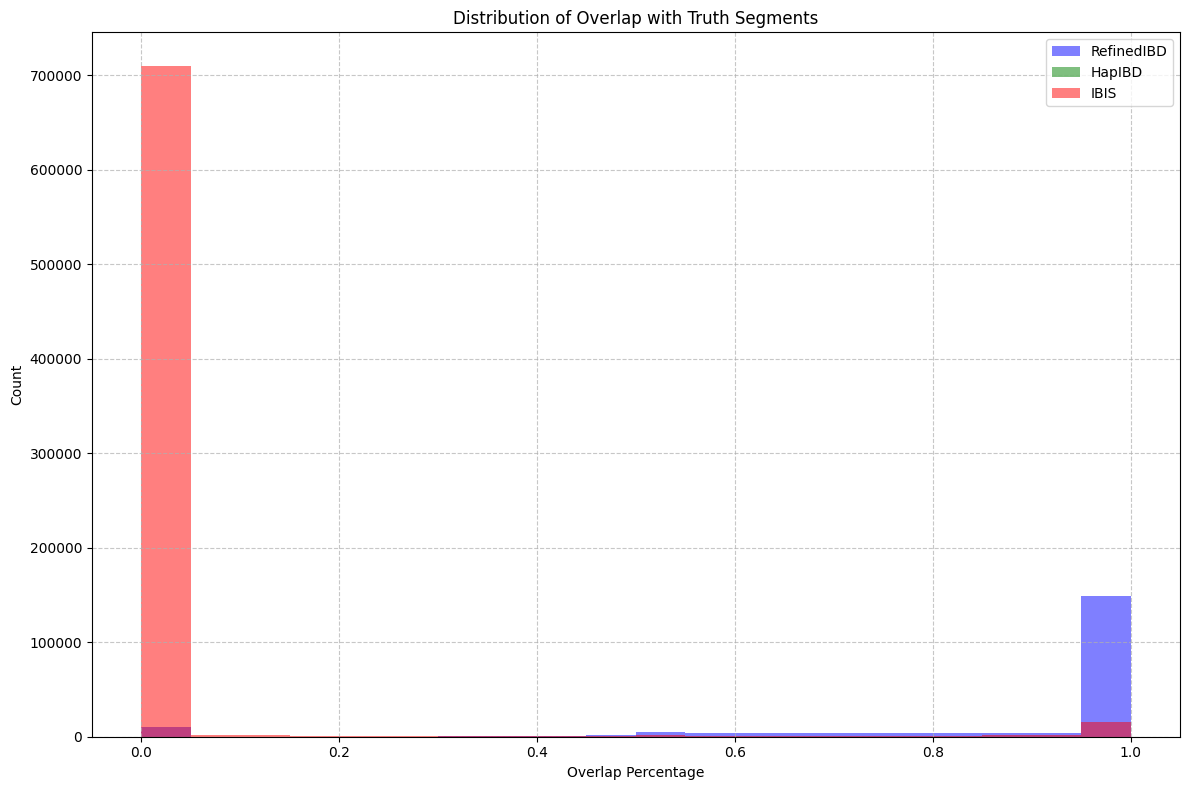

In [46]:
# Generate visualizations
print("Generating visualizations...")
plot_length_distribution(all_results, truth_df)
plot_precision_recall(all_results, truth_df)
plot_roc_curves(all_results, truth_df)
plot_overlap_histogram(all_results)

In [49]:
def calculate_summary_metrics(all_results, truth_df):
    """Calculate summary statistics for each tool"""
    metrics = []
    
    # Count total truth segments
    total_truth = len(truth_df)
    print(f"Total truth segments: {total_truth}")
    
    for tool_name in ['RefinedIBD', 'HapIBD', 'IBIS']:
        tool_df = all_results[all_results['tool'] == tool_name]
        
        if len(tool_df) == 0:
            print(f"No segments found for {tool_name}, skipping metrics")
            continue
        
        # Count true positives (segments with >50% overlap)
        true_positives = tool_df['detected_truth'].sum()
        
        # Count false positives (segments with ≤50% overlap)
        false_positives = len(tool_df) - true_positives
        
        # Count truth segments detected by this tool
        detected_truth_ids = set([x for x in tool_df['truth_id'] if x is not None])
        detected_truths = len(detected_truth_ids)
        
        # Calculate recall (proportion of truth segments detected)
        recall = detected_truths / total_truth if total_truth > 0 else 0
        
        # Calculate precision (proportion of detected segments that are true)
        precision = true_positives / len(tool_df) if len(tool_df) > 0 else 0
        
        # Calculate F1 score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Print detailed debug info
        print(f"\n{tool_name} Summary:")
        print(f"  Total segments: {len(tool_df)}")
        print(f"  True positives: {true_positives} ({true_positives/len(tool_df)*100:.2f}% of segments)")
        print(f"  False positives: {false_positives} ({false_positives/len(tool_df)*100:.2f}% of segments)")
        print(f"  Unique truth segments detected: {detected_truths} ({detected_truths/total_truth*100:.2f}% of truth)")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        
        metrics.append({
            'Tool': tool_name,
            'Total Segments': len(tool_df),
            'True Positives': true_positives,
            'False Positives': false_positives,
            'Detected Truth Segments': detected_truths,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    # Check if we have meaningful metrics
    if len(metrics_df) == 0 or metrics_df['True Positives'].sum() == 0:
        print("\n⚠️ WARNING: No true positives detected across any tool!")
        print("This suggests an issue with matching segments to ground truth.")
        print("Possible causes:")
        print("1. Column name mismatches between tool output and truth data")
        print("2. Sample ID format differences")
        print("3. Chromosome notation differences (e.g., 'chr1' vs '1')")
        print("4. Position coordinate system differences")
    
    return metrics_df

# Calculate and display summary metrics
print("Calculating summary metrics...")
metrics_df = calculate_summary_metrics(all_results, truth_df)
display(metrics_df)

Calculating summary metrics...
Total truth segments: 183061

RefinedIBD Summary:
  Total segments: 200681
  True positives: 186641 (93.00% of segments)
  False positives: 14040 (7.00% of segments)
  Unique truth segments detected: 128531 (70.21% of truth)
  Precision: 0.9300
  Recall: 0.7021
  F1 Score: 0.8002
No segments found for HapIBD, skipping metrics

IBIS Summary:
  Total segments: 748898
  True positives: 26951 (3.60% of segments)
  False positives: 721947 (96.40% of segments)
  Unique truth segments detected: 40961 (22.38% of truth)
  Precision: 0.0360
  Recall: 0.2238
  F1 Score: 0.0620


,Tool,Total Segments,True Positives,False Positives,Detected Truth Segments,Precision,Recall,F1 Score
0,RefinedIBD,200681,186641,14040,128531,0.930038,0.702121,0.800166
1,IBIS,748898,26951,721947,40961,0.035988,0.223756,0.062003


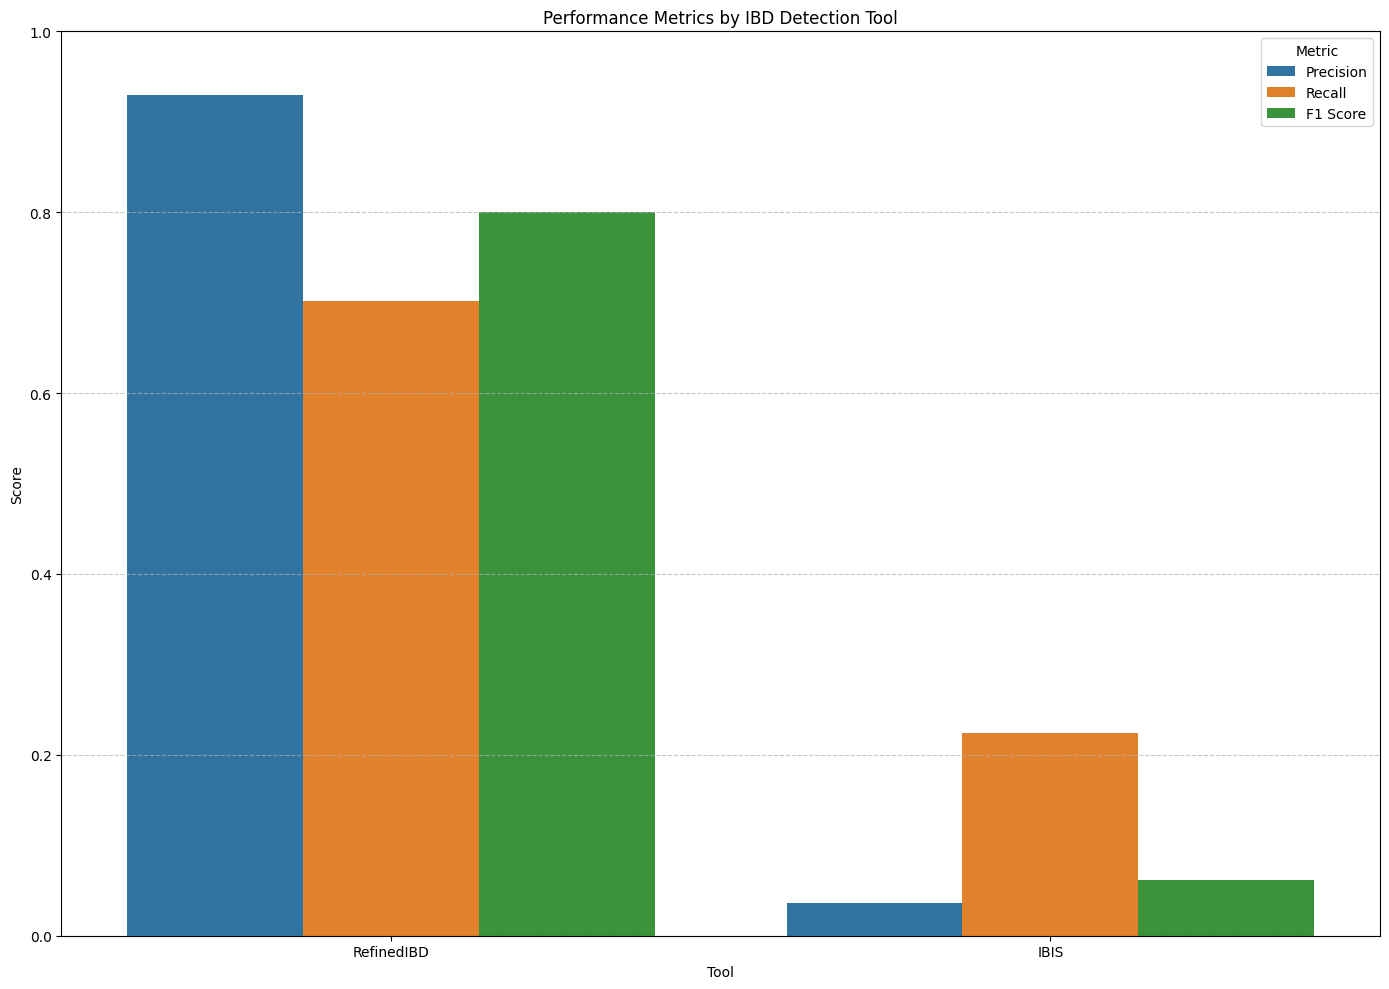

In [51]:
def plot_summary_barplot(metrics_df):
    """Plot summary metrics as a bar chart"""
    plt.figure(figsize=(14, 10))
    
    # Melt the dataframe to make it suitable for grouped bar chart
    plot_metrics = ['Precision', 'Recall', 'F1 Score']
    plot_df = pd.melt(metrics_df, id_vars=['Tool'], value_vars=plot_metrics, 
                      var_name='Metric', value_name='Value')
    
    # Create grouped bar chart
    sns.barplot(x='Tool', y='Value', hue='Metric', data=plot_df)
    
    plt.title('Performance Metrics by IBD Detection Tool')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.savefig('ibd_performance_metrics.png')
    plt.show()
    
plot_summary_barplot(metrics_df)

2025-03-05 09:10:35,294 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-05 09:10:35,302 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-05 09:10:35,339 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-05 09:10:35,344 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-05 09:10:35,379 - INFO - Using categorical units to plot a list of strings that are all parsable as 

<Figure size 1600x1200 with 0 Axes>

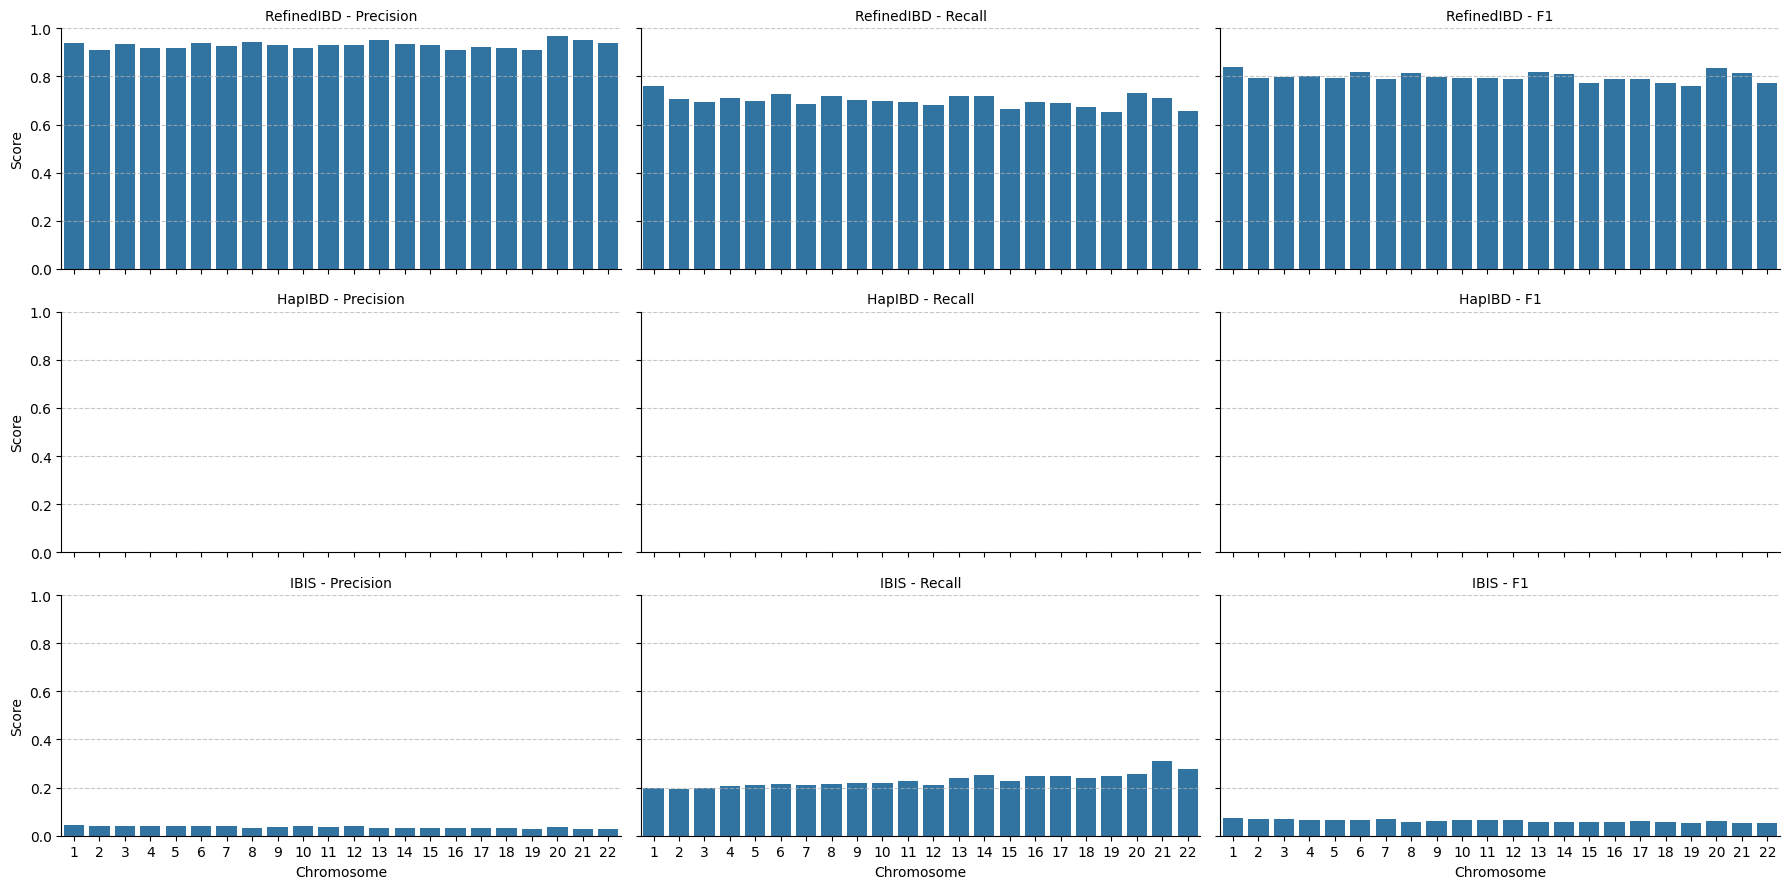

In [52]:
def plot_chromosome_performance(all_results, truth_df):
    """Plot performance metrics by chromosome"""
    # Get unique chromosomes
    all_chroms = sorted(truth_df['chrom'].unique())
    
    # Initialize metrics dictionary
    chrom_metrics = {tool: {chrom: {'precision': 0, 'recall': 0, 'f1': 0} 
                           for chrom in all_chroms} 
                    for tool in ['RefinedIBD', 'HapIBD', 'IBIS']}
    
    # Calculate metrics per chromosome
    for chrom in all_chroms:
        # Count truth segments in this chromosome
        truth_in_chrom = truth_df[truth_df['chrom'] == chrom]
        total_truth = len(truth_in_chrom)
        
        for tool in ['RefinedIBD', 'HapIBD', 'IBIS']:
            # Get tool results for this chromosome
            tool_results = all_results[(all_results['tool'] == tool) & 
                                       (all_results['chrom'] == chrom)]
            
            if len(tool_results) == 0:
                continue
                
            # Count true positives
            true_positives = tool_results['detected_truth'].sum()
            
            # Count detected truth segments
            detected_truth_ids = set([x for x in tool_results['truth_id'] if x is not None])
            detected_truths = len(detected_truth_ids)
            
            # Calculate metrics
            precision = true_positives / len(tool_results) if len(tool_results) > 0 else 0
            recall = detected_truths / total_truth if total_truth > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            chrom_metrics[tool][chrom]['precision'] = precision
            chrom_metrics[tool][chrom]['recall'] = recall
            chrom_metrics[tool][chrom]['f1'] = f1
    
    # Create dataframes for plotting
    plot_data = []
    for tool in chrom_metrics:
        for chrom in chrom_metrics[tool]:
            for metric in ['precision', 'recall', 'f1']:
                plot_data.append({
                    'Tool': tool,
                    'Chromosome': chrom,
                    'Metric': metric.capitalize(),
                    'Value': chrom_metrics[tool][chrom][metric]
                })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Plot
    plt.figure(figsize=(16, 12))
    g = sns.FacetGrid(plot_df, col='Metric', row='Tool', height=3, aspect=2)
    g.map_dataframe(sns.barplot, x='Chromosome', y='Value')
    g.set_axis_labels('Chromosome', 'Score')
    g.set_titles('{row_name} - {col_name}')
    
    for ax in g.axes.flat:
        ax.set_ylim(0, 1)
        ax.grid(True, linestyle='--', alpha=0.7, axis='y')
        
    plt.tight_layout()
    plt.savefig('ibd_chromosome_performance.png')
    plt.show()
    
plot_chromosome_performance(all_results, truth_df)

In [ ]:
def plot_accuracy_by_length(all_results, truth_df):
    """Plot detection accuracy as a function of segment length"""
    plt.figure(figsize=(12, 8))
    
    # Bin truth segments by length
    bins = [0, 1e4, 5e4, 1e5, 5e5, 1e6, 5e6, float('inf')]
    bin_labels = ['<10kb', '10-50kb', '50-100kb', '0.1-0.5Mb', '0.5-1Mb', '1-5Mb', '>5Mb']
    
    # Add length bins to truth dataframe
    truth_df['length_bin'] = pd.cut(truth_df['length'], bins=bins, labels=bin_labels)
    
    # Count total truth segments per bin
    truth_counts = truth_df.groupby('length_bin', observed=True).size()
    
    # For each tool, calculate detection rate by length bin
    for tool_name, color in zip(['RefinedIBD', 'HapIBD', 'IBIS'], ['blue', 'green', 'red']):
        detection_rates = []
        
        for bin_label in bin_labels:
            # Get truth segments in this bin
            bin_truth = truth_df[truth_df['length_bin'] == bin_label]
            total = len(bin_truth)
            
            if total == 0:
                detection_rates.append(0)
                continue
            
            # Count how many were detected by this tool
            tool_df = all_results[all_results['tool'] == tool_name]
            detected = 0
            
            for _, truth_row in bin_truth.iterrows():
                truth_id = truth_row['segment_id']
                if (tool_df['truth_id'] == truth_id).any():
                    detected += 1
            
            detection_rates.append(detected / total if total > 0 else 0)
        
        plt.plot(bin_labels, detection_rates, marker='o', label=tool_name, color=color, linewidth=2)
    
    plt.title('IBD Detection Rate by Segment Length')
    plt.xlabel('Segment Length')
    plt.ylabel('Detection Rate')
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig('ibd_detection_by_length.png')
    plt.show()
    
    # Also create a bar chart showing segment counts by length
    plt.figure(figsize=(10, 6))
    truth_counts.plot(kind='bar', color='purple')
    plt.title('Number of Truth Segments by Length')
    plt.xlabel('Segment Length')
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.savefig('ibd_truth_segments_by_length.png')
    plt.show()
    
plot_accuracy_by_length(all_results, truth_df)

/tmp/ipykernel_1084/4125887138.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  truth_counts = truth_df.groupby('length_bin').size()
